# EG01-EG24 Transition Scenario
The following jupyter notebook demonstrates the usage of CYCLUS to run
an EG01 to EG24 transition scenario. 

### Import Necessary Module and Set Path 
Necessary modules for analysis are imported.

In [5]:
import sqlite3 as lite
import os
import sys
import collections
from pyne import nucname
sys.path.insert(0, '../scripts/')
jupyter_directory = os.getcwd()

### The analysis.py file is a simple sqlite query and plotting script to analyze and visualize cyclus SQL output files. The script can be found in [https://github.com/arfc/transition-scenarios](https://github.com/arfc/transition-scenarios)

In [6]:
import analysis as an

## Run Cyclus Input file
The CYCLUS input file is already made in the same directory as this notebook file. The next cell will run the xml file and output an SQL file. For more options on running cyclus, run `cyclus -h`

In [9]:
# Removes previous cyclus output file, just in case.
! rm cyclus.sqlite

# Runs xml input file
! cyclus eg01-eg24-complex.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

## Wait for the Complete message..

### The output file should be named 
         
          cyclus.sqlite

### The analysis.py works mostly like such:
    1. function returns a dictionary of timeseries (massflow, installed power, etc)
    2. plotting function (stacked_bar or line_plot) creates plots out of the dictionary
    3. png file is saved in the directory of the notebook file.

In [ ]:
# define filename to create sqlite cursor for analysis
filename = 'cyclus.sqlite'


# get sqlite cursor using a function in analysis.py
cur = an.get_cursor(filename)


# get simulation time info
init_year, init_month, duration, timestep = an.get_timesteps(cur)


# get fuel mass timeseries
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'sfr_fuel'])
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

# prints net capacity and number of reactor timeseries
an.plot_power(cur)

# get tailings mass timeseries
agent_ids = an.get_agent_ids(cur, 'enrichment')
tailings = an.facility_commodity_flux(cur, agent_ids,
                                        ['tailings'], True)
an.stacked_bar_chart(tailings, timestep,
                  'Year', 'Mass [MTHM]',
                  'Tailings vs Time',
                  'tailings', init_year)

# natural uranium demand
nat_u = collections.OrderedDict()
nat_u['nat_u'] = an.nat_u_timeseries(cur)
an.stacked_bar_chart(nat_u, timestep,
                     'Years', 'Natural Uranium Mass',
                     'Natural Uranium Demand vs Time',
                     'nat_u', init_year)

# uranium utilization
dictionary = {}
dictionary['uranium_utilization'] = an.u_util_calc(cur)
an.stacked_bar_chart(dictionary, timestep,
                     'Years', 'U Utilization Factor',
                     'U Utilization vs Time',
                     'u_util', init_year)

# get reprocessed material flow
agent_ids = an.get_agent_ids(cur, 'separations')
combined = an.facility_commodity_flux(cur, agent_ids, ['uox_TRU', 'sfr_TRU'], True)
from_spent_uox = an.facility_commodity_flux(cur, agent_ids, ['uox_TRU'], True)
from_spent_mox = an.facility_commodity_flux(cur, agent_ids, ['sfr_TRU'], True)
an.stacked_bar_chart(combined, timestep, 'Years', 'Mass[MTHM]',
                  'Total TRU reprocessed outflux vs Time', 'combined',
                  init_year)
an.stacked_bar_chart(from_spent_uox, timestep, 'Years', 'Mass[MTHM]',
                  'TRU reprocessed from spent UOX vs Time', 'from_spent_uox',
                  init_year)
an.stacked_bar_chart(from_spent_mox, timestep, 'Years', 'Mass[MTHM]',
                  'TRU reprocessed from spent MOX vs Time', 'from_spent_mox',
                  init_year)

print('Finished!')

sink_source_facilities has no values
sink_source_facilities has no values


## The benefits of using a jupyter notebook is that one can run sqlite queries if a question rises.

In [10]:
# Like such:

# Number of Reactors Deployed
cur = an.get_cursor(filename)

# Number of LWRs Deployed
lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "lwr"').fetchone()
print('The Number of LWRs Deployed:')
print(lwr[0])

# Number of SFRs deployed
sfr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "fr"').fetchone()
print('The Number of FRs Deployed:')
print(sfr[0])

The Number of LWRs Deployed:
391
The Number of FRs Deployed:
2041


In [11]:
# Fresh and Spent Fuel Composition
cur = an.get_cursor(filename)

sfr_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "sfr_fuel"').fetchone()
fresh_sfr_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                                 'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh sfr fuel: ')
for isotope in fresh_sfr_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

print('\n \n')

sfr_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "sfr_waste_recipe"').fetchall()
print('Composition for sfr spent fuel: ')
for isotope in sfr_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

Composition for fresh sfr fuel: 
U232: 8.251413836213829e-08 %
U233: 1.8267817354113106e-07 %
U234: 0.014183553277000016 %
U235: 0.657768668601456 %
U236: 0.4708047231546309 %
U238: 84.9572427897746 %
Np237: 0.6575939269214587 %
Pu238: 0.3146562839163647 %
Pu239: 6.547873807427567 %
Pu240: 3.136848216227294 %
Pu241: 1.8976528661777947 %
Pu242: 0.9325269424504185 %
Pu244: 3.0925912332086166e-05 %
Am241: 0.06954822099672987 %
Am242M: 0.0009211927952601164 %
Am243: 0.21416062381412654 %
Cm242: 0.027957456523596214 %
Cm243: 0.0008322840980884815 %
Cm244: 0.09242152229923964 %
Cm245: 0.006176546958610714 %
Cm246: 0.0007875583119542776 %
Cm247: 1.0794865085453715e-05 %
Cm248: 8.303040755965326e-07 %
Cm250: 4.621076114961982e-15 %

 

Composition for sfr spent fuel: 
H3: 0.0 %
He4: 0.0 %
Kr81: 1.5299332870879223e-09 %
Kr85: 0.0 %
Sr90: 0.08869178475872014 %
Tc99: 0.2771618273710004 %
I129: 0.08869178475872014 %
Cs134: 0.0 %
Cs135: 0.4767183430781207 %
Cs137: 0.4212859776039206 %
Pb206: 1.3414

### Simulation Results

This cell outputs a file that contains all the metrics for this transition scenario.

In [12]:
outstring = ''
outstring += 'Initial Year:' + str(init_year) + '\n'
outstring += 'Initial Month:' + str(init_month) + '\n'
outstring += 'Duration in Months:' + str(duration) + '\n'
outstring += 'End Year:' + str(int(init_year + duration/12)) + '\n'

outstring += '\n'

outstring += 'Total Fuel Used: [MTHM]' + '\n'
first = True
for key in fuel_dict:
    outstring += '\t' + key + ': ' + str(max(fuel_dict[key])) + '\n'
    if first:
        total = fuel_dict[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, fuel_dict[key])]
outstring += '\t' + key + ': ' + str(max(total)) + '\n'

outstring += '\n'

outstring += 'Total Natural Uranium [MTHM]' + '\n'
outstring += '\t' + str(max(nat_u['nat_u'])) + '\n'

outstring += 'Total Tailings [MTHM]' + '\n'
outstring += '\t' + str(max(tailings['tailings'])) + '\n'

outstring += '\n'

outstring += 'Average Fuel Utilization Factor (Fuel/NatU):' + '\n'
outstring += '\t' + str(sum(dictionary['uranium_utilization']) / len(dictionary['uranium_utilization'])) + '\n'

outstring += '\n'

outstring += 'Plutonium reprocessed: [MTHM]' + '\n'
first = True
for key in combined:
    outstring += '\t' + key + ': ' + str(max(combined[key])) + '\n'
    if first:
        total = combined[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, combined[key])]
outstring += '\t Total: ' + str(max(total)) + '\n'

outstring += '\n' 

outstring += 'Reactors Deployed:' + '\n'
outstring += '\t LWR: ' + str(lwr[0]) + '\n'
outstring += '\t FR: ' + str(sfr[0]) + '\n'

outstring += '\n'

outstring += 'Compositions' + '\n'
outstring += '\t Composition for fresh sfr fuel: ' + '\n'
for isotope in fresh_sfr_mox_comp:
    outstring += '\t\t ' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'
    
outstring += '\t Composition for fresh sfr spent fuel: ' + '\n'
for isotope in sfr_waste_comp:
    outstring += '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'

    
print(outstring)
if 'simulation_results':
    with open('simulation_results', 'w') as output:
        output.write(outstring)

Initial Year:1959
Initial Month:1
Duration in Months:3024
End Year:2211

Total Fuel Used: [MTHM]
	uox: 625005.68
	sfr_fuel: 423266.676
	sfr_fuel: 1048272.356

Total Natural Uranium [MTHM]
	4373652.24754
Total Tailings [MTHM]
	3748646.56754

Average Fuel Utilization Factor (Fuel/NatU):
	0.155312906861

Plutonium reprocessed: [MTHM]
	uox_TRU: 7156.63341375
	sfr_TRU: 70033.3196414
	 Total: 77189.9530551

Reactors Deployed:
	 LWR: 391
	 FR: 2041

Compositions
	 Composition for fresh sfr fuel: 
		 U232: 8.251413836213829e-08 %
		 U233: 1.8267817354113106e-07 %
		 U234: 0.014183553277000016 %
		 U235: 0.657768668601456 %
		 U236: 0.4708047231546309 %
		 U238: 84.9572427897746 %
		 Np237: 0.6575939269214587 %
		 Pu238: 0.3146562839163647 %
		 Pu239: 6.547873807427567 %
		 Pu240: 3.136848216227294 %
		 Pu241: 1.8976528661777947 %
		 Pu242: 0.9325269424504185 %
		 Pu244: 3.0925912332086166e-05 %
		 Am241: 0.06954822099672987 %
		 Am242M: 0.0009211927952601164 %
		 Am243: 0.21416062381412654 %
	

### Plots
Plots can viewed inside the notebook, but also on your local directory.

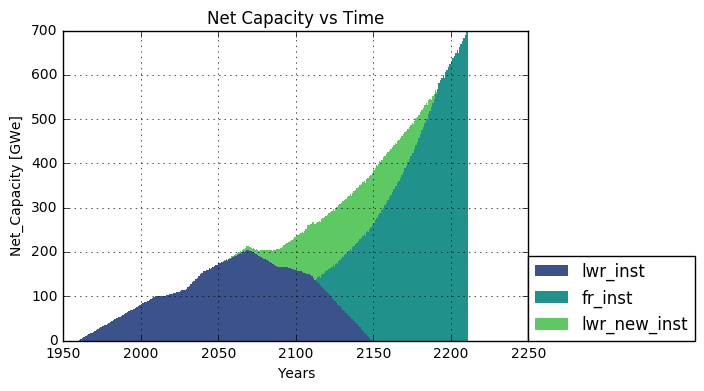

In [13]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')


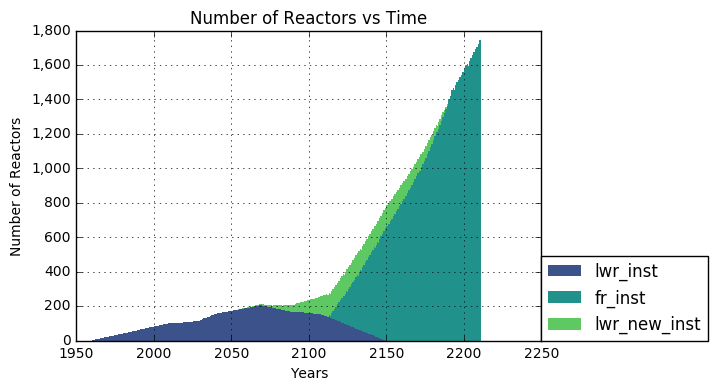

In [14]:

# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')


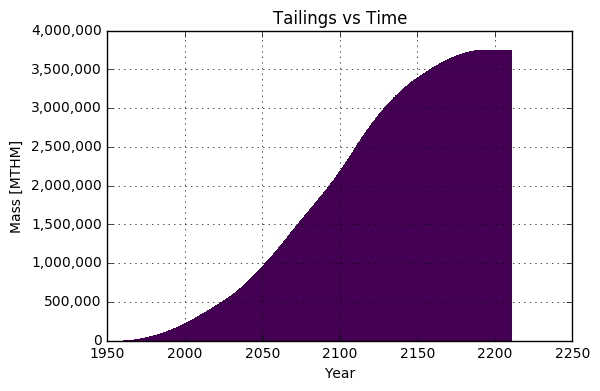

In [15]:

# Display Tailings vs Time
from IPython.display import Image
Image(filename='tailings.png')


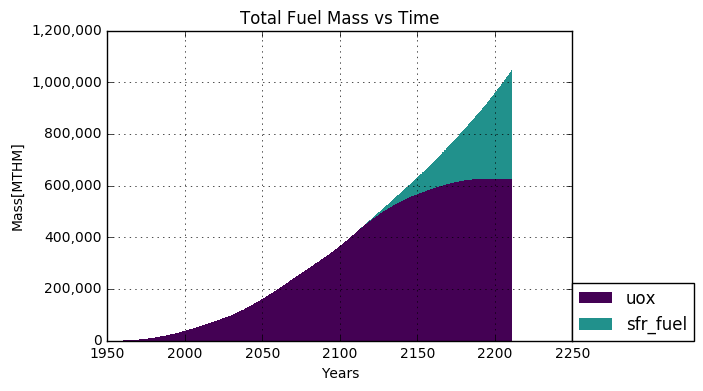

In [16]:

# Display Total Fuel vs Time
from IPython.display import Image
Image(filename='total_fuel.png')


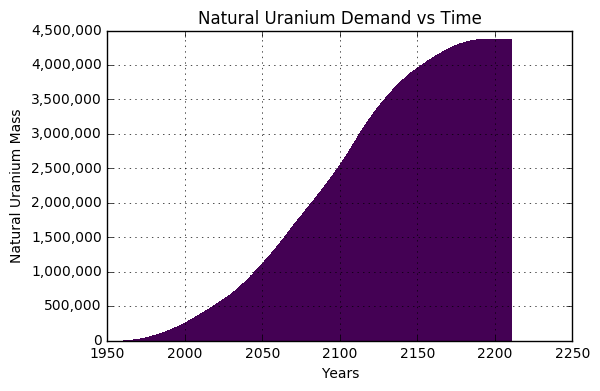

In [17]:

# Display Natural Uranium vs Time
from IPython.display import Image
Image(filename='nat_u.png')

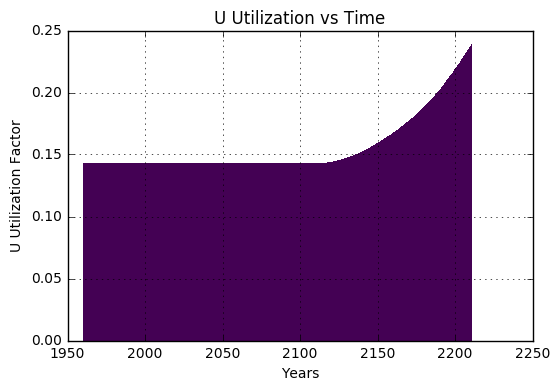

In [18]:

# Display Uranium Utilization vs Time
from IPython.display import Image
Image(filename='u_util.png')


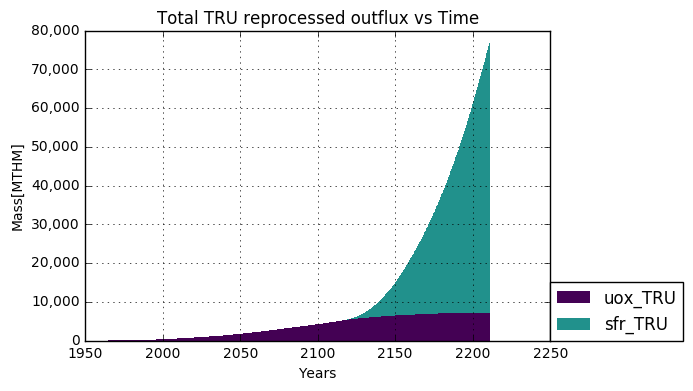

In [19]:

# Display Separated Pu Flow
from IPython.display import Image
Image(filename='combined.png')


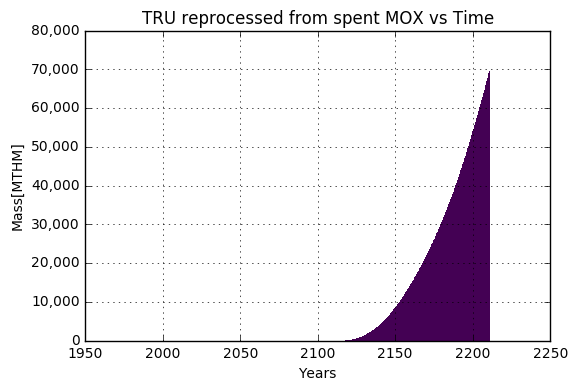

In [20]:

from IPython.display import Image
Image(filename='from_spent_mox.png')


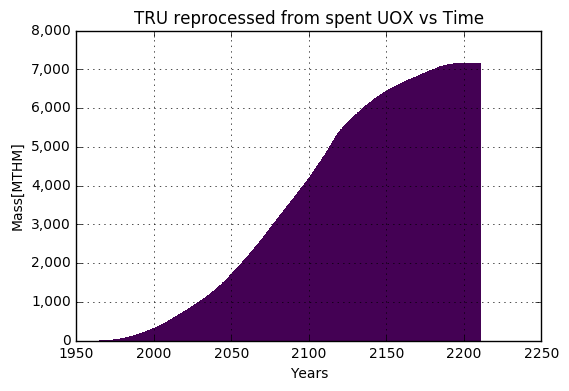

In [21]:

from IPython.display import Image
Image(filename='from_spent_uox.png')